In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load the Philippine waters shapefile
phil_waters = gpd.read_file("/home/cs-iesm-geostorm/Data/gis/vector/boundaries/waters/philippine_waters_filled.shp")



ERROR 1: PROJ: proj_create_from_database: Open of /home/cs-iesm-geostorm/WRF_Intel/miniconda3/envs/research/share/proj failed


In [2]:
# Load the IBTrACS data CSV
ibtracs = pd.read_csv("/home/cs-iesm-geostorm/Data/gis/vector/ibtracs/ibtracs.WP.list.v04r01.csv", low_memory=False ,skiprows = [1])
ibtracs = ibtracs[ibtracs.SEASON>=1979]

In [3]:
ph_shape = phil_waters.geometry.iloc[0]
ph_buffered = ph_shape.buffer(0.5)  # 0.5 degrees (since CRS is EPSG:4326)

In [4]:
# Step 2: Get unique storm IDs
unique_sids = ibtracs["SID"].unique()

In [5]:
# For testing, let's do just one TC
sid = unique_sids[0]
tc = ibtracs[ibtracs["SID"] == sid].copy()

In [6]:
# Create GeoDataFrame for TC points
tc_gdf = gpd.GeoDataFrame(
    tc,
    geometry=gpd.points_from_xy(tc["LON"], tc["LAT"]),
    crs="EPSG:4326"
)

# Step 3: Check which points are within 0.5° buffered area
tc_gdf["within_ph"] = tc_gdf.geometry.within(ph_buffered)

# Step 4: Count how many points are within
n_inside = tc_gdf["within_ph"].sum()

print(f"{sid} has {n_inside} points inside the 0.5° buffered Philippine waters.")


1978361N02180 has 0 points inside the 0.5° buffered Philippine waters.


In [8]:
results = []

for sid in ibtracs["SID"].unique():
    tc = ibtracs[ibtracs["SID"] == sid].copy()

    tc_gdf = gpd.GeoDataFrame(
        tc,
        geometry=gpd.points_from_xy(tc["LON"], tc["LAT"]),
        crs="EPSG:4326"
    )

    tc_gdf["within_ph"] = tc_gdf.geometry.within(ph_buffered)
    n_inside = tc_gdf["within_ph"].sum()

    # Estimate TC lifetime within PH (in hours)
    hours_inside = n_inside * 3

    results.append({"SID": sid, "n_points": n_inside, "hours_inside": hours_inside})


In [10]:
df_tc_lifetime = pd.DataFrame(results)
print(df_tc_lifetime.head())

# Optionally: average TC lifetime within PH waters
avg_hours = df_tc_lifetime["hours_inside"].mean()
print(f"Average TC lifetime inside 0.5° buffered Philippine waters: {avg_hours:.1f} hours")


             SID  n_points  hours_inside
0  1978361N02180         0             0
1  1979077N07150         0             0
2  1979098N02144        24            72
3  1979126N04148        35           105
4  1979137N19116         0             0
Average TC lifetime inside 0.5° buffered Philippine waters: 8.5 hours


In [11]:
# After looping and collecting results
df_inside = df_tc_lifetime[df_tc_lifetime["n_points"] > 0]

# Average lifetime inside PH (for storms that entered)
avg_hours = df_inside["hours_inside"].mean()
print(f"Average TC lifetime inside PH buffer (only those that entered): {avg_hours:.1f} hours")

print(f"Out of {len(df_tc_lifetime)}, {len(df_inside)} storms entered the buffer.")


Average TC lifetime inside PH buffer (only those that entered): 27.8 hours
Out of 1507, 460 storms entered the buffer.


In [15]:
import matplotlib.pyplot as plt

# Step 2: Filter only rows with SIDs that entered PH buffer
entered_sids = df_tc_lifetime[df_tc_lifetime["n_points"] > 0]["SID"]
ibtracs_entered = ibtracs[ibtracs["SID"].isin(entered_sids)].copy()

# Step 3: Convert to GeoDataFrame
gdf_tracks = gpd.GeoDataFrame(
    ibtracs_entered,
    geometry=gpd.points_from_xy(ibtracs_entered["LON"], ibtracs_entered["LAT"]),
    crs="EPSG:4326"
)

# Step 4: Add a "within buffer" column (bulk check)
gdf_tracks["within_ph"] = gdf_tracks.geometry.within(ph_buffered)



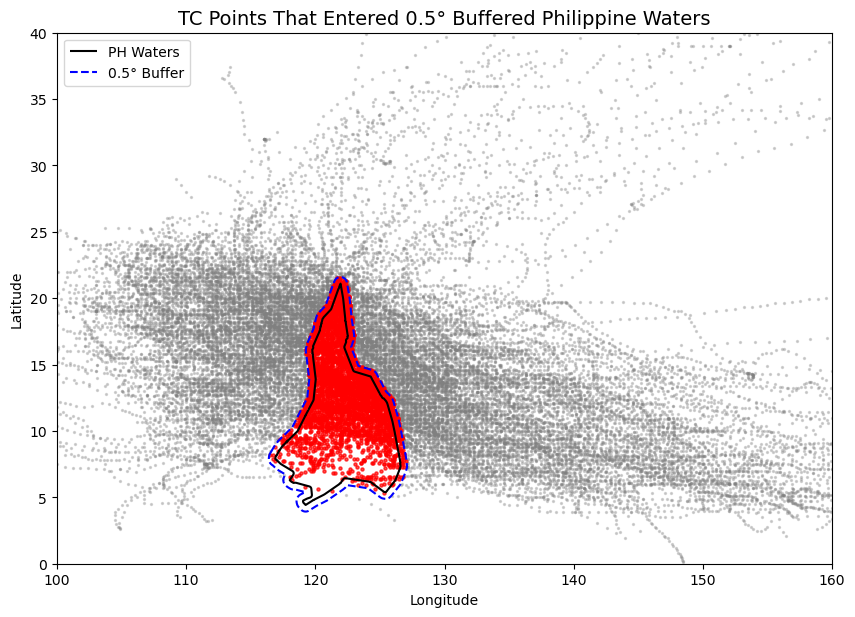

In [16]:
fig, ax = plt.subplots(figsize=(10, 12))

# Plot boundaries
phil_waters.boundary.plot(ax=ax, color="black", label="PH Waters")
gpd.GeoSeries(ph_buffered).boundary.plot(ax=ax, color="blue", linestyle="--", label="0.5° Buffer")

# Plot TC points
gdf_tracks[~gdf_tracks["within_ph"]].plot(ax=ax, markersize=2, color="gray", alpha=0.3)
gdf_tracks[gdf_tracks["within_ph"]].plot(ax=ax, markersize=5, color="red", alpha=0.7)

# Zoom in to the western Pacific / Philippine region
ax.set_xlim(100, 160)
ax.set_ylim(0, 40)

# Decorations
ax.set_title("TC Points That Entered 0.5° Buffered Philippine Waters", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.show()
